In [29]:
import torch
from torch.optim import SGD
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
import torchvision

In [30]:
data_folder = '~/data/FMNIST'
data = torchvision.datasets.FashionMNIST(root=data_folder, download=True, train=True)


In [31]:
data.data.shape, data.targets.shape

(torch.Size([60000, 28, 28]), torch.Size([60000]))

In [32]:
class Data(Dataset):
    def __init__(self, x: torch.Tensor, y: torch.Tensor):
        x = x.float()
        self.x = x.view(-1, 28*28)
        self.y = y
    def __len__(self):
        return len(self.x)
    def __getitem__(self, index):
        x, y = self.x[index], self.y[index]
        return x.to('cuda'), y.to('cuda')

In [33]:
X = data.data
y = data.targets

In [34]:
def get_data():
    dataset = Data(X, y)   
    dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
    return dataloader

In [35]:
# params and hyperparams 
device = 'cuda'
learning_rate = 0.01



In [36]:
def get_model():
    model = nn.Sequential(
        nn.Linear(28*28, 1000),
        nn.ReLU(),
        nn.Linear(1000, 10)
    ).to(device='cuda')
    loss_function = nn.CrossEntropyLoss()
    optimizer = SGD(model.parameters(), lr=0.01)
    return model, loss_function, optimizer

In [37]:
def train_batch(x, y, model: nn.Sequential, opt: SGD, loss_function: nn.CrossEntropyLoss):
    model.train()
    prediction = model(x)
    batch_loss = loss_function(prediction, y)
    batch_loss.backward()
    opt.step()
    opt.zero_grad()
    return batch_loss.item()

In [38]:
@torch.no_grad()
def accuracy(x, y, model):
    model.eval()
    prediction = model(x)
    max_value, argmaxes = prediction.max(-1)
    is_correct = argmaxes == y
    return is_correct.cpu().numpy().tolist()

In [39]:
trn_dl = get_data()
model, loss_fn, optimizer = get_model()

In [40]:

losses, accuracies = [], []
for epoch in range(5):
    print(epoch)
    epoch_losses, epoch_accuracies = [], []
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        epoch_losses.append(batch_loss)
    epoch_loss = np.array(epoch_losses).mean()
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        epoch_accuracies.extend(is_correct)
    epoch_accuracy = np.mean(epoch_accuracies)
    losses.append(epoch_loss)
    accuracies.append(epoch_accuracy)

0
1
2
3
4


/tmp/ipykernel_18362/1668084199.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


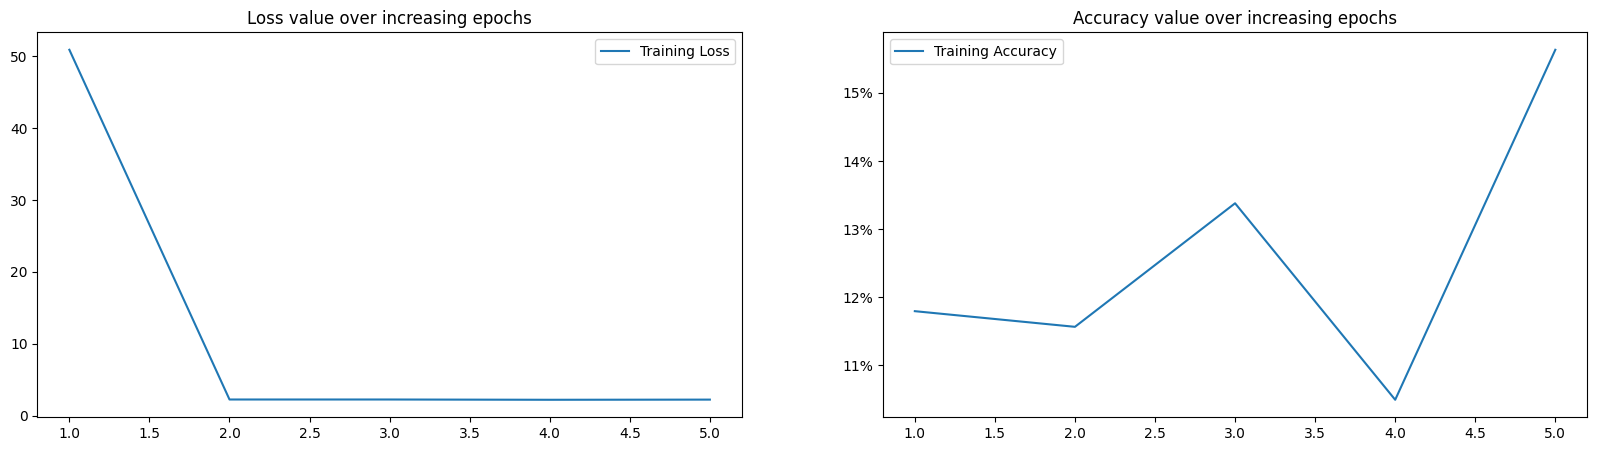

In [41]:
epochs = np.arange(5)+1
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.title('Loss value over increasing epochs')
plt.plot(epochs, losses, label='Training Loss')
plt.legend()
plt.subplot(122)
plt.title('Accuracy value over increasing epochs')
plt.plot(epochs, accuracies, label='Training Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.legend()

In [78]:
'acc is: ' + str((torch.tensor(accuracies).max()).item() * 100) + ' %'

'acc is: 15.633333333333333 %'